In [1]:
'''
Section Description: Setting up environment for running cuml on colabs
'''
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 89 (delta 19), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Now that most people have migrated, we have rem0ved the migration notice.
2. default stable version is now 0.13.  Nightly is now 0.14
3. You can now declare your RAPIDS version as a CLI option and skip the user prompts (ex: '0.13' or '0.14', between 0.11 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/ra

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Reading Raster Image
Creating input matrix
Original Shape (4835, 3402, 11)
New Shape: (16448670, 11)
Going to start kmeansHierarchical
[1 4 3 4 2 1 4 5 2 1 1 4 1 6 3 2 5 6 3 2 1 1 4 5 1 0 3 3 1 5 4 1 1 3 4 2 4
 5 3 3 6 2 2 4 1 3 3 4 3 2 1 6 5 1 4 4 1 4 3 1 6 2 3 4 4 1 2 3 1 2 2 1 2 1
 6 4 6 1 1 1 1 5 2 5 4 3 5 4 1 2 1 1 2 3 2 3 3 6 3 2 3 4 1 4 2 4 0 3 3 3 4
 4 3 2 6 6 2 6 3 1 5 1 1 3 5 2 1 6 1 1 6 1 1 1 5 5 3 4 1 3 3 4 3 6 1 1 1 6
 5 2 3 1 5 1 2 4 4 5 2 1 3 1 3 4 3 3 3 3 4 1 4 6 2 4 1 2 3 5 1 4 3 5 3 1 3
 3 4 2 3 6 2 1 0 3 3 2 4 1 2 3 2 6 1 3 2 4 3 6 1 3 2 4 3 5 3 1 2 4 3 1 6 1
 3 1 1 1 5 2 2 2 3 1 3 1 4 4 1 4 3 3 1 3 1 1 3 4 5 6 1 1 1 3 2 3 1 2 4 4 1
 4 5 4 2 6 5 3 3 4 1 1 1 1 2 4 4 6 2 4 4 1 3 3 1 1 4 3 4 1 6 5 3 4 1 4 1 2
 1 0 5 1 2 4 5 1 5 4 1 1 3 3 3 2 4 1 3 4 6 1 3 3 1 4 2 4 1 5 3 1 2 1 1 3 4
 3 1 1 4 6 5 1 3 5 4 3 1 3 3 3 4 4 3 3 3 2 3 5 2 4 1 2 4 5 

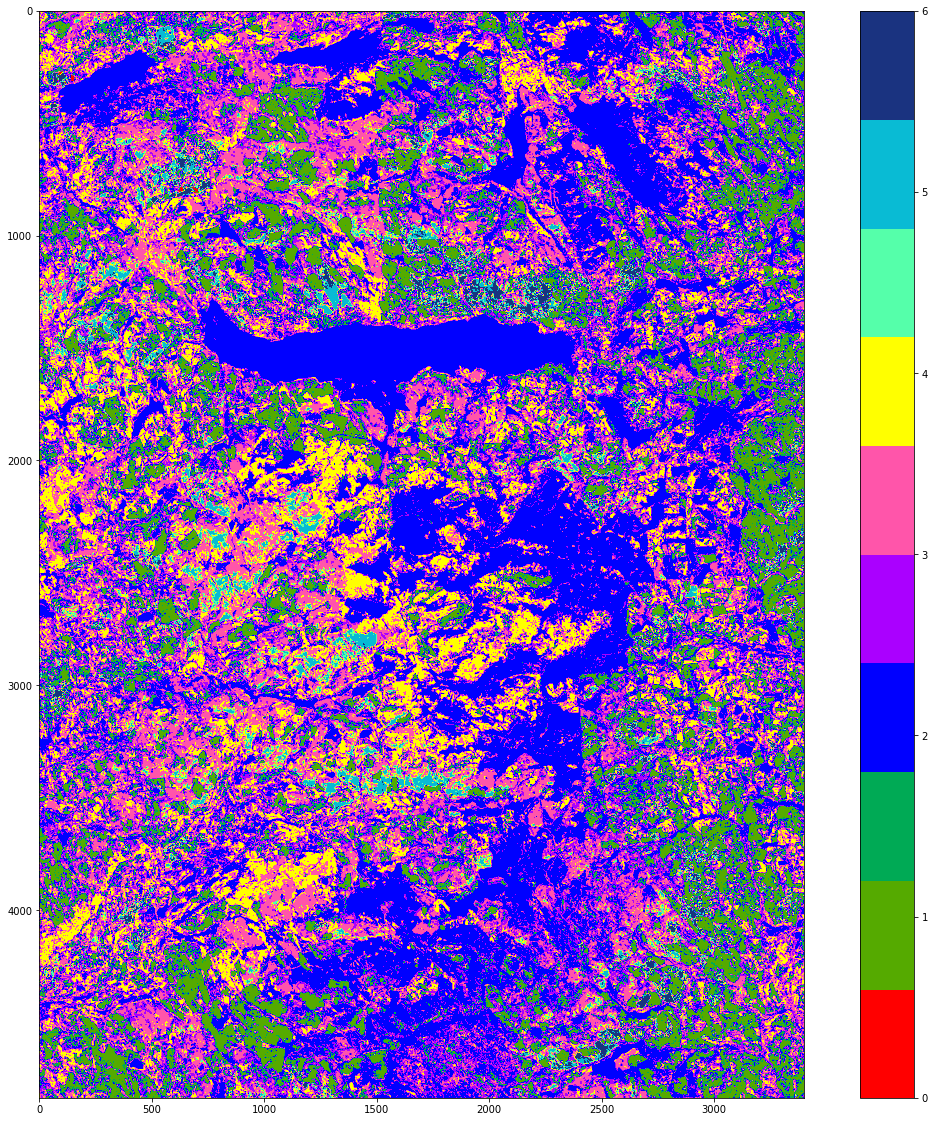

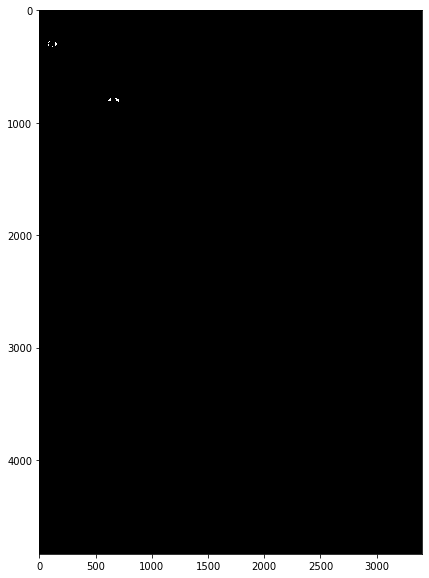

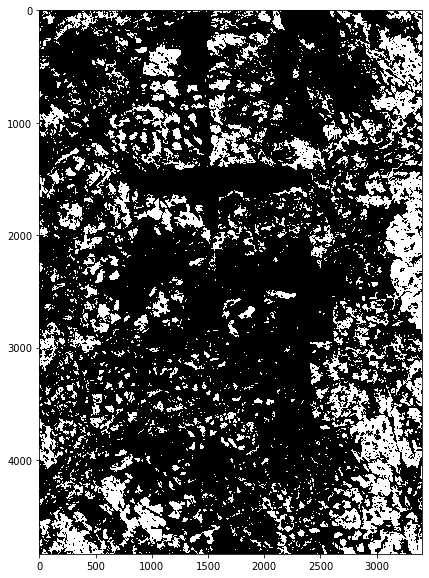

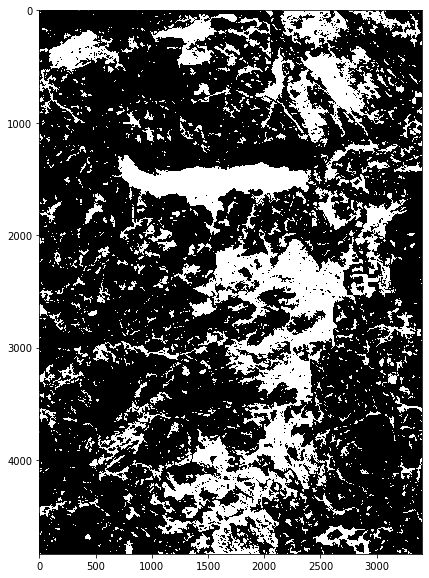

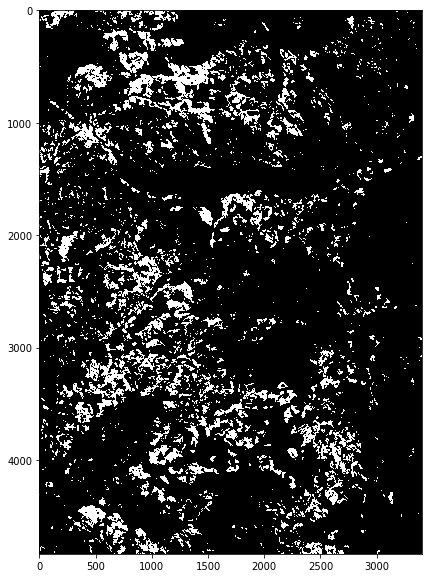

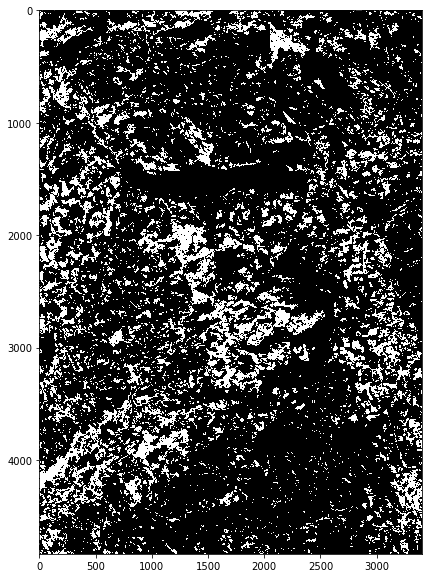

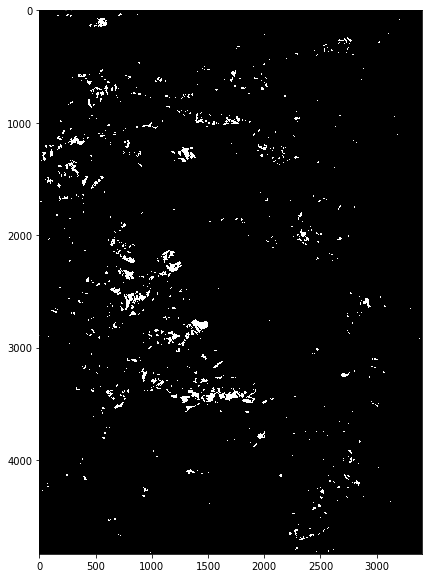

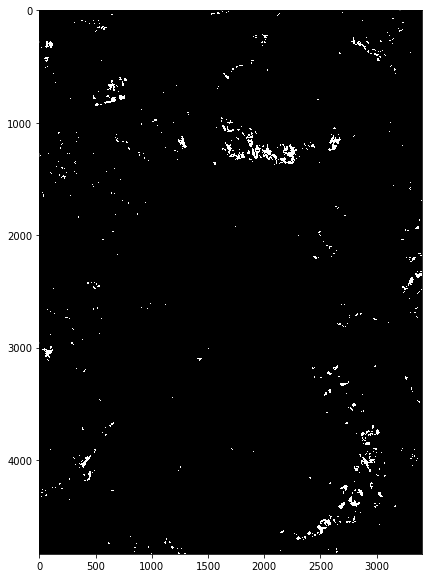

In [21]:
'''
Section Description: Doing K Means Clustering and comparing it with the truth data
'''
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
import cuml
#from cuml import KMeans as cumlKMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#numba imports
from numba import njit

# #raster io imports
# import rasterio
# from rasterio.plot import show

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()

# mounting the google drive
drive.mount('/content/gdrive')

rawImagePath = "/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/"
colorMapImagePath = "/content/gdrive/My Drive/Color_Maps/"
#imageName = "S2A.bin_4x.bin_sub"
imageName = "output4_select2"
imageExtension = ".bin"

image = rawImagePath + imageName + imageExtension

new_image = "/content/gdrive/My Drive/20200302data/output4_select2.bin"
new_colormap_save_path = "/content/gdrive/My Drive/20200302data/K_Means_Color_Maps/K10/"
new_hierarachical_colormap_save_path = "/content/gdrive/My Drive/20200302data/Hierarchical_K_Means_Color_Maps/SeedK1000_Step20_K10/"
new_k_means_hiearacchical_colormap_save_path = "/content/gdrive/My Drive/20200302data/K_Means_Hierarchical_Color_Maps/SeedK1000_K7/"
david_data_dutchlake = "/content/gdrive/My Drive/david_data/dutchlake.tif"

#Truth Data Layers
broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

save_colormap_path="/content/gdrive/My Drive/K_Means_Color_Maps/K14/"

dir = '/content/gdrive/My Drive/20200302data/' # directory that contains truth labels

# Params
K = 10
MAX_K = 20
init = 'k-means++'
n_init = 10
# number of processors to use (default 1, -1 uses all processors)
n_jobs = -1


#list containing the all the layers created from k-means
individual_layers=[]

def showImage(filepath):
    image = cv2.imread(filepath)
    #cv2_imshow(image)
    plt.show(image)
    plt.show()


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds, normalization = False):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
      if(normalization != True):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()
      else:
        image[:, :, band] = normalize(image_ds.GetRasterBand(band + 1).ReadAsArray(), norm='l2', copy=True)

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image

def np2cudf(df):
    # convert numpy array to cuDF dataframe
    df = pd.DataFrame({'fea%d'%i:df[:,i] for i in range(df.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
      pdf[str(c)] = df[column]
    return pdf 


def runKMeans(K, X, image):
    start = time.time()
    print("Running K Means", "\nK =", K)
    k_means = KMeans(n_clusters=K, init=init, n_init=n_init,
                     n_jobs=n_jobs, verbose=1)
    print("Fitting K Means")
    k_means.fit(X)
    print("Creating clusters")
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(image[:, :, 0].shape)
    print("Clusters created")
    stop = time.time()
    totalProcessTime = stop - start
    print("Time: " + str(totalProcessTime))
    return X_cluster

def cumlKMeans(K, X, image):
  start = time.time()
  print('Running cuml K Means', '\nK = ', K)
  k_means = cuml.KMeans(n_clusters=K)#-1 indicates us all the available GPUs
  print('cuML KMeans')
  k_means.fit(X)
  print('Creating Clusters')
  X_cluster = k_means.labels_
  X_cluster = X_cluster.reshape(image[:, :, 0].shape)
  print("Clusters created")
  stop = time.time()
  totalProcessTime = stop - start
  print("Time: " + str(totalProcessTime))
  return X_cluster

def hierarchicalKMeans( K, X, image, seed_K=1000, step=50):
  print('Going to start Hierarchical KMeans')
  
  if(step>K):
    epochs = int(seed_K/step)+1
  else:
    epochs = int(seed_K/K)+1
  
  cluster_indexes = []
  final_X_cluster = None
  for i in range(epochs):
    print('Starting Kmeans for epoch: ', i+1)
    if(i==epochs-1):
      k_means = cuml.KMeans(n_clusters=K)
    else:
      k_means = cuml.KMeans(n_clusters=seed_K)
    k_means.fit(X)
    cluster_centers = k_means.cluster_centers_
    X_cluster = k_means.labels_
    #for the next iteration cluster centers of the previous run will be clustered
    X = cluster_centers

    cluster_indexes_m = []

    #storing the indexes of original clusters
    if(i==0):
      final_X_cluster = X_cluster
      for j in range(seed_K):
        np_labels = np.array(X_cluster)
        cluster_indexes_j = np.where(np_labels==j)
        # print(cluster_indexes_j)
        cluster_indexes.append(np.array(cluster_indexes_j[0]))

      print("ended")     
    
    else:
      print(seed_K)
      for j in range(seed_K):
        np_labels_ = np.array(X_cluster)
        cluster_indexes_ = np.where(np_labels_==j)
        cluster_indexes_j = np.array((cluster_indexes_[0]))
        print(np_labels_)
        print(cluster_indexes_j)
        print(cluster_indexes_j.shape)
        for cluster_index in cluster_indexes_j:
          cluster_indexes_tc = cluster_indexes[cluster_index]
          for index_tc in cluster_indexes_tc:
            final_X_cluster[index_tc] = j
              
        a_b = []

        for k in range(cluster_indexes_j.shape[0]):
          a_b = a_b + cluster_indexes[cluster_indexes_j[k]].tolist()  

        cluster_indexes_m.append(np.array(a_b))
        print('length of cluster_indexes_ : ', len(cluster_indexes_m))  


      seed_K = seed_K - step
      cluster_indexes = cluster_indexes_m

    print('New length of cluster indexes came out ot be: ', len(cluster_indexes)) 
          
  print('So the clusters we have: ', np.unique(final_X_cluster))
  return final_X_cluster.reshape(image[:, :, 0].shape)    


def kmeansHierarchical(X, image, seed_K = 5000, distance_threshold=3, num_clusters=None):
  print('Going to start kmeansHierarchical')
  k_means = cuml.KMeans(n_clusters=seed_K)
  k_means.fit(X)
  cluster_centers = k_means.cluster_centers_
  X = cluster_centers
  final_X_cluster = k_means.labels_
  cluster_indexes = []
  for j in range(seed_K):
    np_labels = np.array(final_X_cluster)
    cluster_indexes_j = np.where(np_labels==j)
    # print(cluster_indexes_j)
    cluster_indexes.append(np.array(cluster_indexes_j[0]))
  
  if(num_clusters==None):
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=distance_threshold, linkage='ward')
  else:
    hierarchical_clustering = AgglomerativeClustering(n_clusters = num_clusters, linkage='ward')
  hierarchical_clustering.fit(X)
  X_cluster = hierarchical_clustering.labels_
  print(X_cluster)
  print('Assigning new cluster labels to the original data')
  for j in range(np.max(X_cluster)+1):
    np_labels_ = np.array(X_cluster)
    cluster_indexes_ = np.where(np_labels_==j)
    cluster_indexes_j = np.array((cluster_indexes_[0]))
    print(np_labels_)
    print(cluster_indexes_j)
    print(cluster_indexes_j.shape)
    for cluster_index in cluster_indexes_j:
      cluster_indexes_tc = cluster_indexes[cluster_index]
      for index_tc in cluster_indexes_tc:
        final_X_cluster[index_tc] = j

  return final_X_cluster.reshape(image[:, :, 0].shape)


def createColorMap(X_cluster, K):
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0),
              (0, 1, 1), (0.1, 0.2, 0.5)]#, (0.8, 0.1, 0.3), (0.4,1,1), (0.5,0,1)]
    print("Creating Color Map")
    cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster, cmap=cm)
    plt.colorbar()
    plt.show
    print("Saving color map image")
    # plt.imsave(new_colormap_save_path + imageName +
    #            "k_7_colormap.png",  X_cluster, cmap=cm)
    plt.imsave(new_k_means_hiearacchical_colormap_save_path+imageName +
           "k_10_colormap.png", X_cluster, cmap=cm)


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(new_colormap_save_path+str(c_no)+".png", colormap_ext, cmap=cm )
   plt.imsave(new_k_means_hiearacchical_colormap_save_path + str(c_no)+".png",colormap_ext, cmap=cm  )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
# @njit(parallel=True)
def compare(layer_type, cluster_n):
  l_ds = readRasterImage(layer_type)
  X, l_img = getInputMatrix(l_ds)
  print(X.shape)
  print(X[0,0])
  water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
  water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
  layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
  layer_k = individual_layers[cluster_n] #layer generated from the k_means
  print('Unique values in the given truth layer: ',np.unique(water_X))
  for index_x in range(water_X.shape[0]):
    for index_y in range(water_X.shape[1]):
      if(water_X[index_x,index_y]==0.0):
        water_X[index_x,index_y]=0
      
      else:
        water_X[index_x,index_y]=1        
  colors = [(0,0,0), (1,1,1)]
  cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
  plt.figure(figsize=(10, 10))
  plt.imshow(water_X, cmap=cm)

  #get the stats
  stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
  #counters for the score
  true_positive=0
  true_negative=0
  false_negative=0
  false_positive=0

  for index_x in range(truth_layer.shape[0]):
    for index_y in range(truth_layer.shape[1]):
      if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
        true_positive+=1
      elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
        false_negative+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
        false_positive+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
        true_negative+=1

  #compute the stats
  precision = true_positive/(true_positive+false_positive)
  print('Precision is:', precision*100, '%')

  recall = true_positive/(true_positive +false_negative)
  print('Recall is: ', recall*100, '%')

  iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
  print('Accuracy(IOU) is: ', iou*100, '%')

  print('True_Positive: ',true_positive)
  print('False_Positive: ',false_positive)
  print('True_Negative: ',true_negative)
  print('False_Negative: ',false_negative)

'''
Function Description: Generate Stats for already generated clustered layers
'''
def gererate_stats_for_each_generated_layer(layers, path, K):
  colormap = cv2.imread(path+str(K)+"/"+ imageName +
                "k_"+str(K)+"_colormap.png")
  gray_scale_colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2GRAY)
  unique_values = np.unique(gray_scale_colormap)
  num=0
  print(unique_values)
  for unique_value in unique_values:
    gray_scale_colormap=np.where(gray_scale_colormap==unique_value, num, gray_scale_colormap)
    num+=1

  print(np.unique(gray_scale_colormap))
  print('Shape of the new gray scale colormpa is: ', gray_scale_colormap.shape)
  for k in range(K):
    create_individual_layer(k,gray_scale_colormap)
  for layer in layers:
    for n in range(K):
       print('Comparing with cluster number: ', n)
       compare(os.path.join(dir,layer ), n)

    



def run():
    #showImage(new_image)
    img_ds = readRasterImage(new_image)
    X, img = getInputMatrix(img_ds, normalization=False)
    # elbow_method(X, MAX_K)
    # new_img = np.zeros((450,450, 4))
    # new_img =  img[:450, :450]
    # new_X = new_img[:, :, :new_img.shape[2]].reshape(450*450,4)
    # X_cluster = cumlKMeans(K, X, img)
    # print(np.unique(new_img))
    # image = rasterio.open(david_data_dutchlake)
    # show(image)

    # original_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(2,5):
    #    original_img[:, :, 4-b] = img[:, :, b]

    # plt.figure(figsize=(7,7))
    # plt.imshow(original_img)  
    # plt.imsave(save_colormap_path+'original.png', original_img)
    # X_cluster = hierarchicalKMeans(K,X, img, seed_K = 1000, step = 20)
    X_cluster = kmeansHierarchical(X, img, seed_K=1000, distance_threshold=25, num_clusters=7)
    createColorMap(X_cluster, K)
    # #create an individual layers for each of the cluster
    create_individual_layer(0, X_cluster)
    create_individual_layer(1, X_cluster)
    create_individual_layer(2, X_cluster)
    create_individual_layer(3, X_cluster)
    create_individual_layer(4, X_cluster)
    create_individual_layer(5, X_cluster)
    create_individual_layer(6, X_cluster)
    # create_individual_layer(7, X_cluster)
    # create_individual_layer(8, X_cluster)
    # create_individual_layer(9, X_cluster)
    # create_individual_layer(10, X_cluster)
    # create_individual_layer(11, X_cluster)
    # create_individual_layer(12, X_cluster)
    # create_individual_layer(13, X_cluster)
    # create_individual_layer(14, X_cluster)
    # create_individual_layer(15, X_cluster)
    # create_individual_layer(16, X_cluster)
    # create_individual_layer(17, X_cluster)

    # compare(broadLeaf_sp,2 ) #compare the clusters with the truth data water
    #compare(ccutbl_sp,2)
    # compare(conifer_sp,2)
    # compare(exposed_sp,2)
    # compare(herb_grass_sp,2)
    # compare(mixed_sp,2)
    # compare(shrub_sp,2)
    # layer='CCUTBL_SP.tif_proj.bin'
    # for n in range(K):
    #   print('Comparing with cluster number: ', n)
    #   compare(os.path.join(dir,layer ), n)

    # print("done")
    # path = "/content/gdrive/My Drive/20200302data/K_Means_Color_Maps/K"
    # layers = ["CONIFER_SP.tif_proj.bin"]
    # gererate_stats_for_each_generated_layer(layers,path,3 )


run()



In [0]:
arr = np.array([54, 19, 46, 63, 13, 57 ,42,  7, 25, 68, 65, 44, 39, 83,  2, 84, 82, 50,  5, 65, 23, 45, 49, 14,
 72, 61, 70 , 3, 21, 54 ,64, 75, 71, 79, 22,  0, 56, 11,  4, 55, 34, 64, 17, 38, 74,  2, 48, 81,
 77 ,60,  1, 66 ])
print(np.where(arr==0))


(array([35]),)


In [0]:
!nvidia-smi

Sat Apr 11 11:05:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    36W / 250W |    623MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


Mounted at /content/gdrive
Unique values in the given truth layer:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 16. 17. 20. 22. 25.
 31.]
LAND_COVER.bin_sub.bin


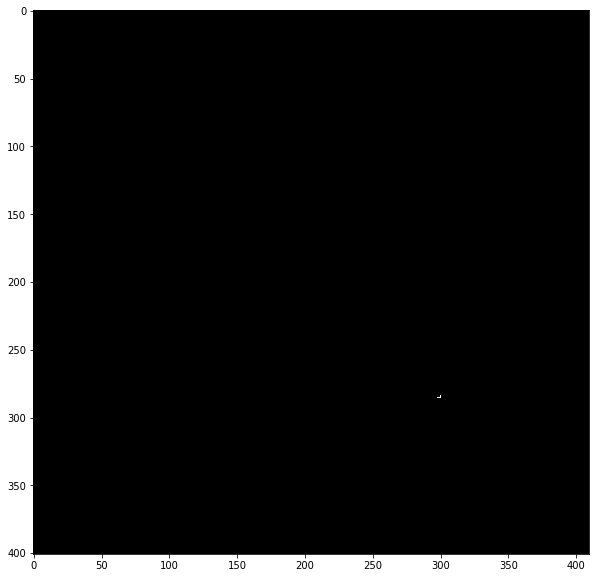

In [0]:
#Studying the new truth data that was provided by Ashlin
#Comparing K_MEan with truth data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive', force_remount=True)
#truth data path
dir = '/content/gdrive/My Drive/Truth_Data/vri_rasterize_subset/subset'

def show_all_truth_data_figures():
    for file in os.listdir(dir):
      if file.endswith(".bin"):
        image_ = os.path.join(dir, file)
        image_ds = gdal.Open(image_, gdal.GA_ReadOnly)
        image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                        gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
        for band in range(image.shape[2]):
            image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    
        new_shape = (image.shape[0] * image.shape[1], image.shape[2])

        X = image[:, :, :13].reshape(new_shape)
        l_img = image
        water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
        water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
        layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
        #  layer_k = individual_layers[cluster_n] #layer generated from the k_means
        # print('Unique values in the given truth layer: ',np.unique(water_X))
        for index_x in range(water_X.shape[0]):
          for index_y in range(water_X.shape[1]):
            if(water_X[index_x,index_y]==10.0):
              water_X[index_x,index_y]=0
            
            else:
              water_X[index_x,index_y]=1
        colors = [(0,0,0), (1,1,1)]
        cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
        plt.figure(figsize=(10, 10))
        print(file)
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.imshow(water_X, cmap=cm)


def show_individual_truth_data_layer(file):
        image_ = os.path.join(dir, file)
        image_ds = gdal.Open(image_, gdal.GA_ReadOnly)
        image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                        gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
        for band in range(image.shape[2]):
            image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    
        new_shape = (image.shape[0] * image.shape[1], image.shape[2])

        X = image[:, :, :13].reshape(new_shape)
        l_img = image
        water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
        water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
        layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
        #  layer_k = individual_layers[cluster_n] #layer generated from the k_means
        print('Unique values in the given truth layer: ',np.unique(water_X))
        for index_x in range(water_X.shape[0]):
          for index_y in range(water_X.shape[1]):
            if(water_X[index_x,index_y]!=12.0):
              water_X[index_x,index_y]=0
            
            else:
              water_X[index_x,index_y]=1
        colors = [(0,0,0), (1,1,1)]
        cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
        plt.figure(figsize=(10, 10))
        print(file)
        plt.rcParams.update({'figure.max_open_warning': 0})
        plt.imshow(water_X, cmap=cm)


def run():
  show_individual_truth_data_layer('LAND_COVER.bin_sub.bin')


run()  


In [0]:
# fuzzy K-Means implementation/ Meanshift with K-means
#Comparing K_MEan with truth data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans, MeanShift
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive')


rawImagePath = "/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/"
colorMapImagePath = "/content/gdrive/My Drive/Color_Maps/"
imageName = "S2A.bin_4x.bin_sub"
imageExtension = ".bin"

image = rawImagePath + imageName + imageExtension

#Truth Data Layers
broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

save_colormap_path="/content/gdrive/My Drive/K_Means_Color_Maps/K14/"

dir = '/content/gdrive/My Drive/Truth_Data/vri_rasterize_subset/subset'

# Params
K = 5
MAX_K = 20
init = 'k-means++'
n_init = 10
# number of processors to use (default 1, -1 uses all processors)
n_jobs = -1


#list containing the all the layers created from k-means
individual_layers=[]

def showImage(filepath):
    image = cv2.imread(filepath)
    plt.show(image)
    plt.show()


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image


def runKMeans(K, X, image):
    start = time.time()
    print("Running K Means", "\nK =", K)
    k_means = KMeans(n_clusters=K, init=init, n_init=n_init,
                     n_jobs=n_jobs, verbose=1)
    print("Fitting K Means")
    k_means.fit(X)
    print("Creating clusters")
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(image[:, :, 0].shape)
    print("Clusters created")
    stop = time.time()
    totalProcessTime = stop - start
    print("Time: " + str(totalProcessTime))
    return X_cluster

def runMeanShift(bandwidth, X, image):
  mean_shift =  MeanShift(bandwidth).fit(X)
  X_cluster = mean_shift.labels_
  X_cluster = X_cluster.reshape(image[:, :, 0].shape)
  return X_cluster


def createColorMap(X_cluster, K):
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0),
              (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    print("Creating Color Map")
    cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster, cmap=cm)
    plt.colorbar()
    plt.show
    print("Saving color map image")
    # plt.imsave(save_colormap_path + imageName +
    #            "k_7_colormap.png",  X_cluster, cmap=cm)


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
  l_ds = readRasterImage(layer_type)
  X, l_img = getInputMatrix(l_ds)
  print(X.shape)
  print(X[0,0])
  water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
  water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
  layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
  layer_k = individual_layers[cluster_n] #layer generated from the k_means
  print('Unique values in the given truth layer: ',np.unique(water_X))
  for index_x in range(water_X.shape[0]):
    for index_y in range(water_X.shape[1]):
      if(water_X[index_x,index_y]==1.0):
        water_X[index_x,index_y]=0
      
      else:
        water_X[index_x,index_y]=1
  colors = [(0,0,0), (1,1,1)]
  cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
  plt.figure(figsize=(10, 10))
  plt.imshow(water_X, cmap=cm)

  #get the stats
  stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
  #counters for the score
  true_positive=0
  true_negative=0
  false_negative=0
  false_positive=0

  for index_x in range(truth_layer.shape[0]):
    for index_y in range(truth_layer.shape[1]):
      if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
        true_positive+=1
      elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
        false_negative+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
        false_positive+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
        true_negative+=1

  #compute the stats
  precision = true_positive/(true_positive+false_positive)
  print('Precision is:', precision*100, '%')

  recall = true_positive/(true_positive +false_negative)
  print('Recall is: ', recall*100, '%')

  iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
  print('Accuracy(IOU) is: ', iou*100, '%')

  print('True_Positive: ',true_positive)
  print('False_Positive: ',false_positive)
  print('True_Negative: ',true_negative)
  print('False_Negative: ',false_negative)





def run():
    showImage(image)
    img_ds = readRasterImage(image)
    X, img = getInputMatrix(img_ds)
    #X_cluster = runKMeans(K, X, img)
    X_cluster = runMeanShift(1, X, img)

    # original_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(2,5):
    #    original_img[:, :, 4-b] = img[:, :, b]

    # plt.figure(figsize=(7,7))
    # plt.imshow(original_img)  
    # plt.imsave(save_colormap_path+'original.png', original_img)
   # print('Tatal number of clusters found:   ',max(X_cluster)+1)

    createColorMap(X_cluster, 5)
    # #create an individual layers for each of the cluster
    create_individual_layer(0, X_cluster)
    create_individual_layer(1, X_cluster)
    create_individual_layer(2, X_cluster)
    create_individual_layer(3, X_cluster)
    create_individual_layer(4, X_cluster)
    create_individual_layer(5, X_cluster)
    create_individual_layer(6, X_cluster)
    create_individual_layer(7, X_cluster)
    create_individual_layer(8, X_cluster)
    # create_individual_layer(9, X_cluster)
    # create_individual_layer(10, X_cluster)
    # create_individual_layer(11, X_cluster)
    # create_individual_layer(12, X_cluster)
    # create_individual_layer(13, X_cluster)
    # create_individual_layer(14, X_cluster)
    # create_individual_layer(15, X_cluster)
    # create_individual_layer(16, X_cluster)
    # create_individual_layer(17, X_cluster)

    # compare(broadLeaf_sp,2 ) #compare the clusters with the truth data water
    #compare(ccutbl_sp,2)
    # compare(conifer_sp,2)
    # compare(exposed_sp,2)
    # compare(herb_grass_sp,2)
    # compare(mixed_sp,2)
    # compare(shrub_sp,2)
    # layer='BCLCS_LEVE.bin_sub.bin'
    # for n in range(K):
    #   print('Comparing with cluster number: ', n)
    #   compare(os.path.join(dir,layer ), n)

    # print("done")


run()



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 12)
New Shape: (164410, 12)
Running K Means 
K = 5
Fitting K Means
Creating clusters
Clusters created
Time: 3.9419918060302734


ValueError: ignored

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Reading Raster Image
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 21)
New Shape: (164410, 21)
Running K Means 
K = 5
Fitting K Means
Creating clusters
Clusters created
Time: 7.990156173706055
Creating Color Map
Saving color map image
Comparing with cluster number:  0
Reading Raster Image
Creating input matrix
Original Shape (401, 410, 1)
New Shape: (164410, 1)
(164410, 1)
1.0
Unique values in the given truth layer:  [1. 2.]
Precision i

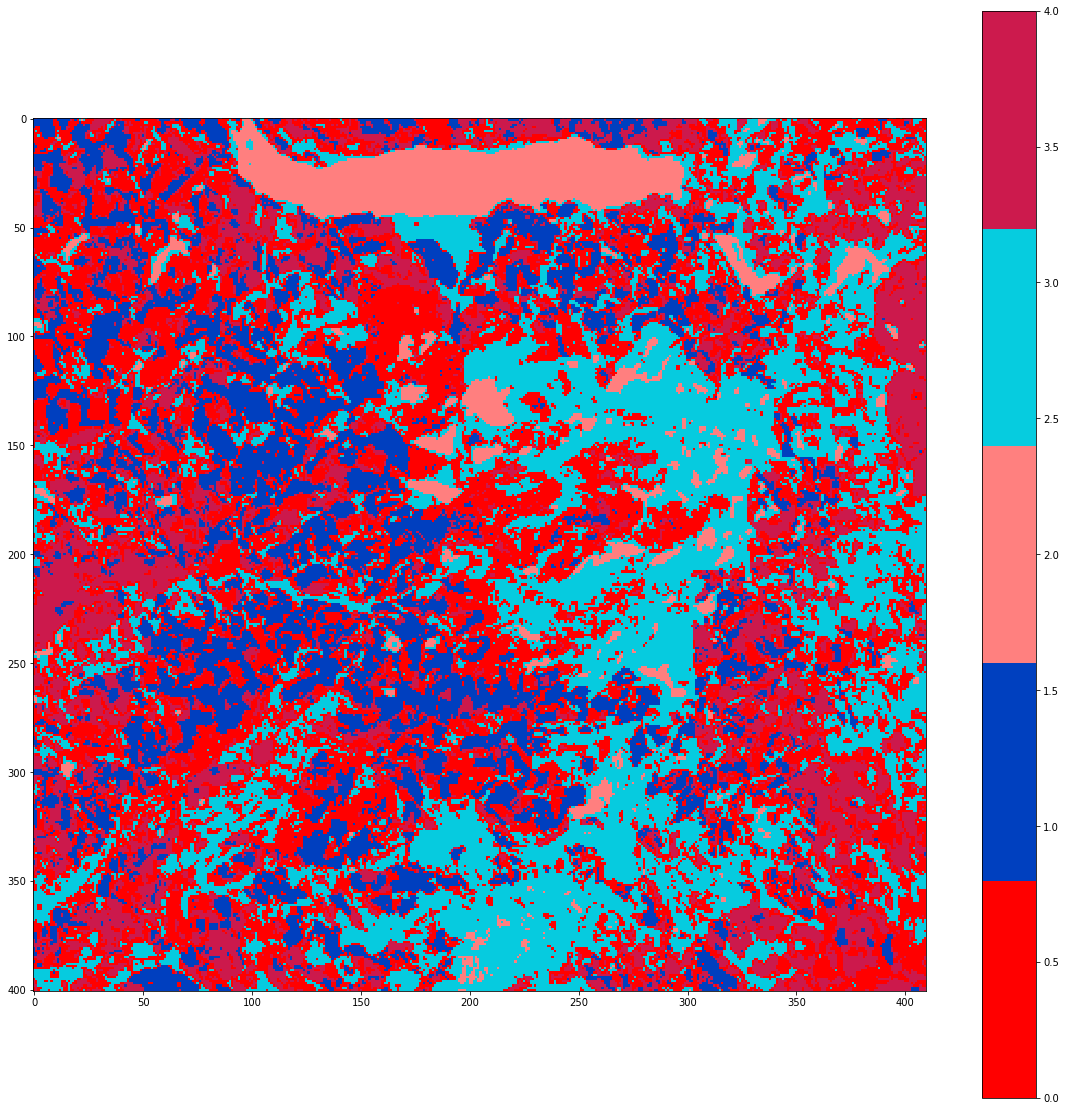

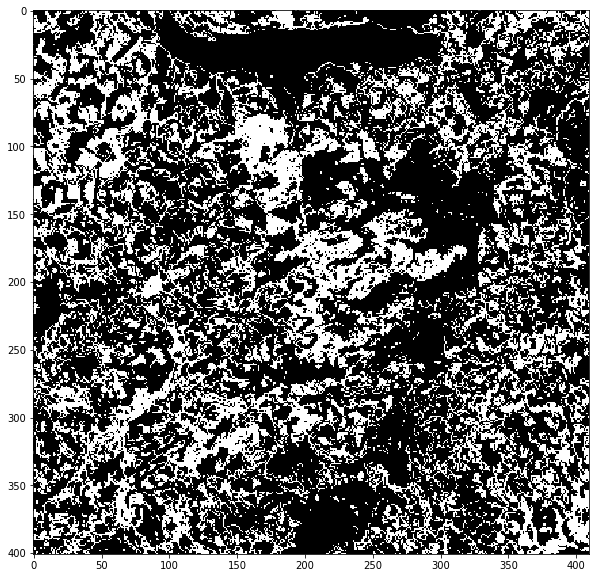

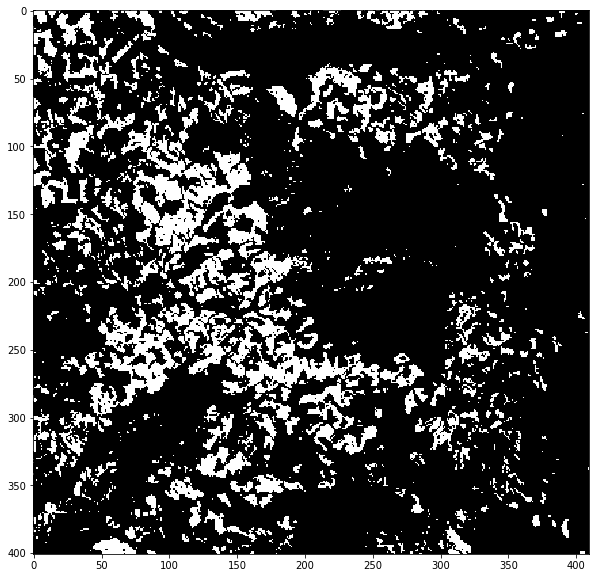

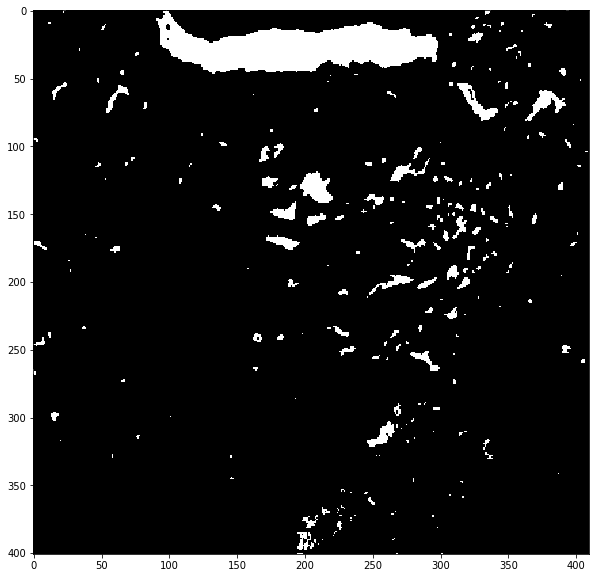

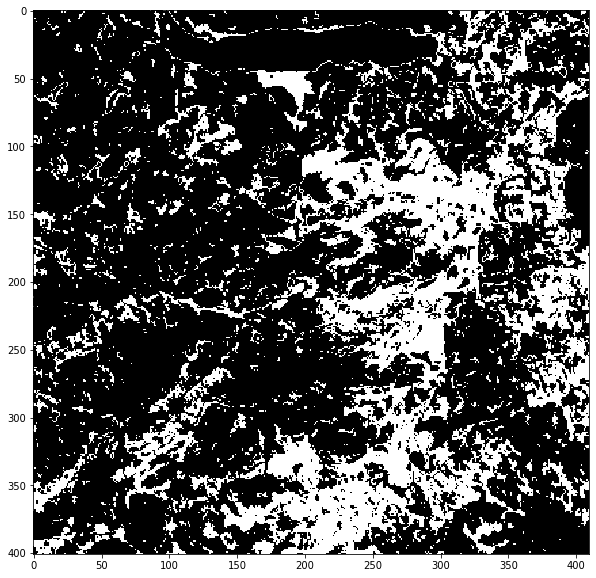

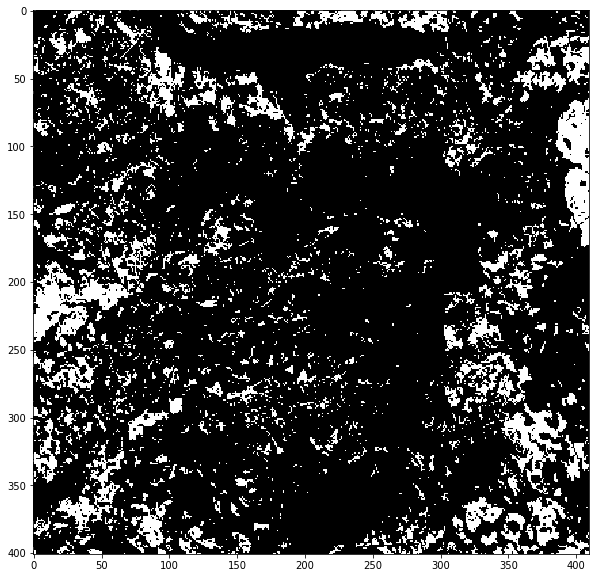

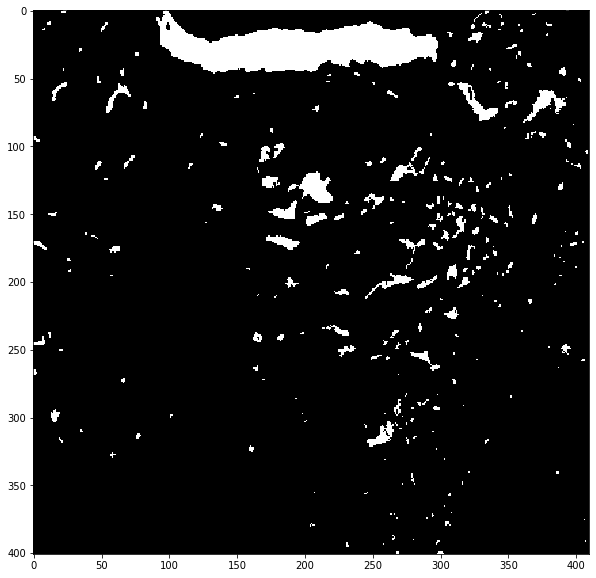

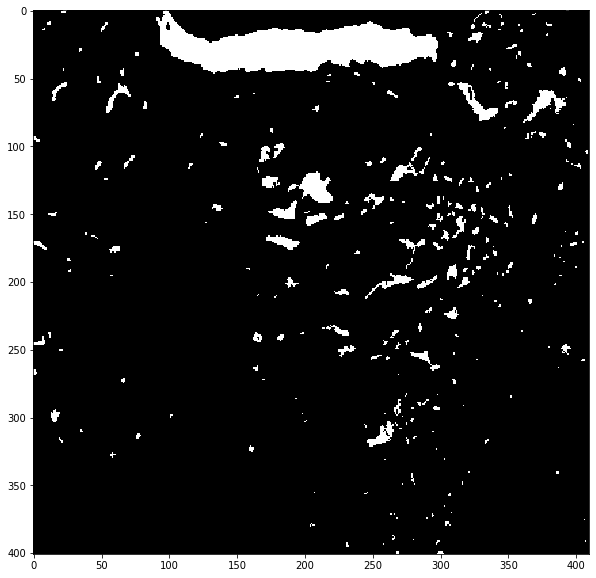

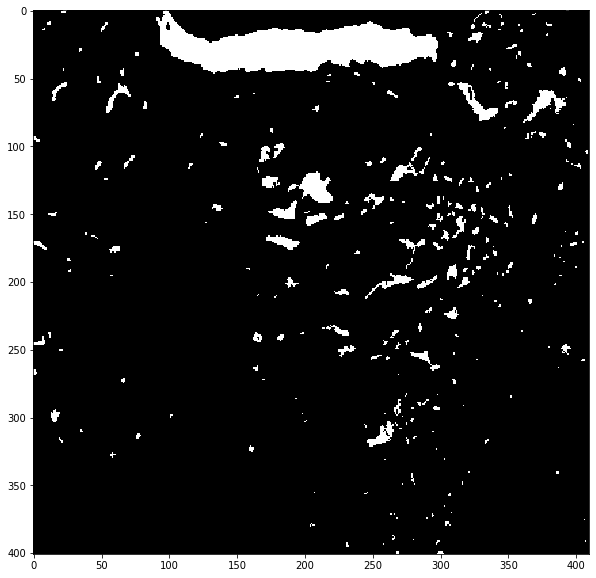

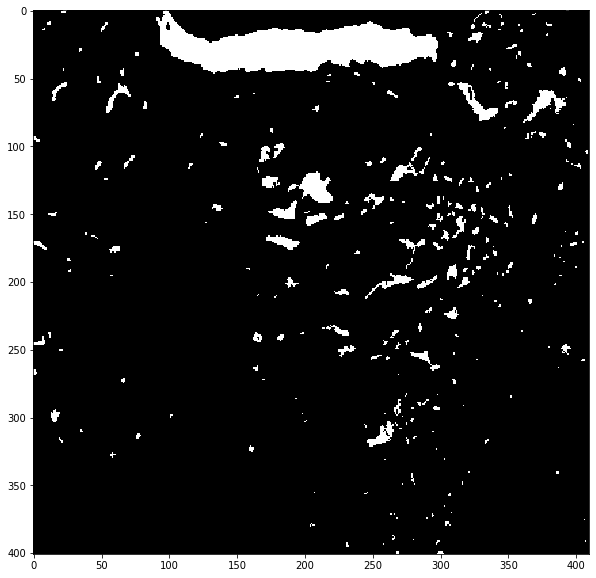

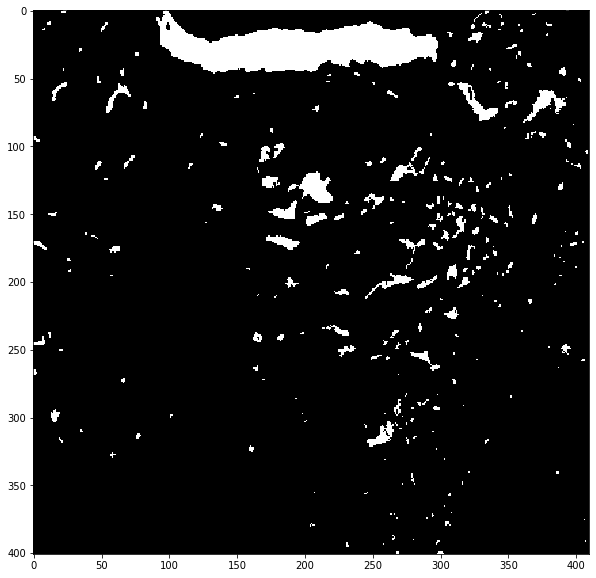

In [0]:
#Comparing K_Means with the joining two data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from sklearn.cluster import KMeans
import numpy as np
from osgeo import gdal, gdal_array
import sys
import math
import time
import os

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

gdal.UseExceptions()
gdal.AllRegister()


# mounting the google drive
drive.mount('/content/gdrive')


rawImagePath = "/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/"
colorMapImagePath = "/content/gdrive/My Drive/Color_Maps/"
imageName = "S2A.bin_4x.bin_sub"
imageExtension = ".bin"

image = rawImagePath + imageName + imageExtension
image2 = rawImagePath + 'L8.bin_4x.bin_sub' + imageExtension

#Truth Data Layers
broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

save_colormap_path="/content/gdrive/My Drive/K_Means_Color_Maps/K14/"

dir = '/content/gdrive/My Drive/Truth_Data/vri_rasterize_subset/subset'

# Params
K = 5
MAX_K = 20
init = 'k-means++'
n_init = 10
# number of processors to use (default 1, -1 uses all processors)
n_jobs = -1


#list containing the all the layers created from k-means
individual_layers=[]

def showImage(filepath):
    image = cv2.imread(filepath)
    plt.show(image)
    plt.show()


def readRasterImage(image):
    print("Reading Raster Image")
    image_ds = gdal.Open(image, gdal.GA_ReadOnly)
    return image_ds


def getInputMatrix(image_ds):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, image_ds.RasterCount),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(image.shape[2]):
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()

    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], image.shape[2])
    print("New Shape:", new_shape)
    X = image[:, :, :13].reshape(new_shape)

    return X, image

def getNewInputMatrix(image_ds, image_ds2):
    image = np.zeros((image_ds.RasterYSize, image_ds.RasterXSize, 21),
                     gdal_array.GDALTypeCodeToNumericTypeCode(image_ds.GetRasterBand(1).DataType))
    print("Creating input matrix")
    for band in range(21):
      if(band>=12):
        image[:, :, band] = image_ds2.GetRasterBand(band-12 + 1).ReadAsArray()
      
      else:
        image[:, :, band] = image_ds.GetRasterBand(band + 1).ReadAsArray()


    print('Original Shape', image.shape)
    new_shape = (image.shape[0] * image.shape[1], 21)
    print("New Shape:", new_shape)
    X = image[:, :, :21].reshape(new_shape)

    return X, image



def runKMeans(K, X, image):
    start = time.time()
    print("Running K Means", "\nK =", K)
    k_means = KMeans(n_clusters=K, init=init, n_init=n_init,
                     n_jobs=n_jobs, verbose=1)
    print("Fitting K Means")
    k_means.fit(X)
    print("Creating clusters")
    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(image[:, :, 0].shape)
    print("Clusters created")
    stop = time.time()
    totalProcessTime = stop - start
    print("Time: " + str(totalProcessTime))
    return X_cluster


def createColorMap(X_cluster, K):
    plt.figure(figsize=(20, 20))
    colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0),
              (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    print("Creating Color Map")
    cm = LinearSegmentedColormap.from_list("Map", colors, N=K)
    plt.imshow(X_cluster, cmap=cm)
    plt.colorbar()
    plt.show
    print("Saving color map image")
    # plt.imsave(save_colormap_path + imageName +
    #            "k_7_colormap.png",  X_cluster, cmap=cm)


def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
  l_ds = readRasterImage(layer_type)
  X, l_img = getInputMatrix(l_ds)
  print(X.shape)
  print(X[0,0])
  water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
  water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
  layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
  layer_k = individual_layers[cluster_n] #layer generated from the k_means
  print('Unique values in the given truth layer: ',np.unique(water_X))
  for index_x in range(water_X.shape[0]):
    for index_y in range(water_X.shape[1]):
      if(water_X[index_x,index_y]==1.0):
        water_X[index_x,index_y]=0
      
      else:
        water_X[index_x,index_y]=1
  colors = [(0,0,0), (1,1,1)]
  cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
  plt.figure(figsize=(10, 10))
  plt.imshow(water_X, cmap=cm)

  #get the stats
  stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
  #counters for the score
  true_positive=0
  true_negative=0
  false_negative=0
  false_positive=0

  for index_x in range(truth_layer.shape[0]):
    for index_y in range(truth_layer.shape[1]):
      if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
        true_positive+=1
      elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
        false_negative+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
        false_positive+=1
      elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
        true_negative+=1

  #compute the stats
  precision = true_positive/(true_positive+false_positive)
  print('Precision is:', precision*100, '%')

  recall = true_positive/(true_positive +false_negative)
  print('Recall is: ', recall*100, '%')

  iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
  print('Accuracy(IOU) is: ', iou*100, '%')

  print('True_Positive: ',true_positive)
  print('False_Positive: ',false_positive)
  print('True_Negative: ',true_negative)
  print('False_Negative: ',false_negative)





def run():
    showImage(image)
    img_ds = readRasterImage(image)
    #X, img = getInputMatrix(img_ds)
    img_ds2 = readRasterImage(image2)
    X, img = getNewInputMatrix(img_ds, img_ds2)

    X_cluster = runKMeans(K, X, img)

    # original_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(2,5):
    #    original_img[:, :, 4-b] = img[:, :, b]

    # plt.figure(figsize=(7,7))
    # plt.imshow(original_img)  
    # plt.imsave(save_colormap_path+'original.png', original_img)

    createColorMap(X_cluster, K)
    #create an individual layers for each of the cluster
    create_individual_layer(0, X_cluster)
    create_individual_layer(1, X_cluster)
    create_individual_layer(2, X_cluster)
    create_individual_layer(3, X_cluster)
    create_individual_layer(4, X_cluster)
    # create_individual_layer(5, X_cluster)
    # create_individual_layer(6, X_cluster)
    # create_individual_layer(7, X_cluster)
    # create_individual_layer(8, X_cluster)
    # create_individual_layer(9, X_cluster)
    # create_individual_layer(10, X_cluster)
    # create_individual_layer(11, X_cluster)
    # create_individual_layer(12, X_cluster)
    # create_individual_layer(13, X_cluster)
    # create_individual_layer(14, X_cluster)
    # create_individual_layer(15, X_cluster)
    # create_individual_layer(16, X_cluster)
    # create_individual_layer(17, X_cluster)

    # compare(broadLeaf_sp,2 ) #compare the clusters with the truth data water
    #compare(ccutbl_sp,2)
    # compare(conifer_sp,2)
    # compare(exposed_sp,2)
    # compare(herb_grass_sp,2)
    # compare(mixed_sp,2)
    # compare(shrub_sp,2)
    layer='BCLCS_LEVE.bin_sub.bin'
    for n in range(K):
      print('Comparing with cluster number: ', n)
      compare(os.path.join(dir,layer ), n)

    print("done")


run()



In [0]:
from cuml.cluster import KMeans

import cudf
import numpy as np
import pandas as pd

def np2cudf(df):
    # convert numpy array to cuDF dataframe
    df = pd.DataFrame({'fea%d'%i:df[:,i] for i in range(df.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
      pdf[str(c)] = df[column]
    return pdf

a = np.asarray([[1.0, 1.0], [1.0, 2.0], [3.0, 2.0], [4.0, 3.0]],dtype=np.float32)
b = np2cudf(a)
print("input:")
print(b)

print("Calling fit")
kmeans_float = KMeans(n_clusters=2, n_gpu=-1)
kmeans_float.fit(b)

print("labels:")
print(kmeans_float.labels_)
print("cluster_centers:")
print(kmeans_float.cluster_centers_)